Cloning into '2155-Challenge-Problem-2'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 68 (delta 2), reused 1 (delta 1), pack-reused 64 (from 1)
Receiving objects: 100% (68/68), 52.85 MiB | 26.51 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/2155-Challenge-Problem-2/2155-Challenge-Problem-2


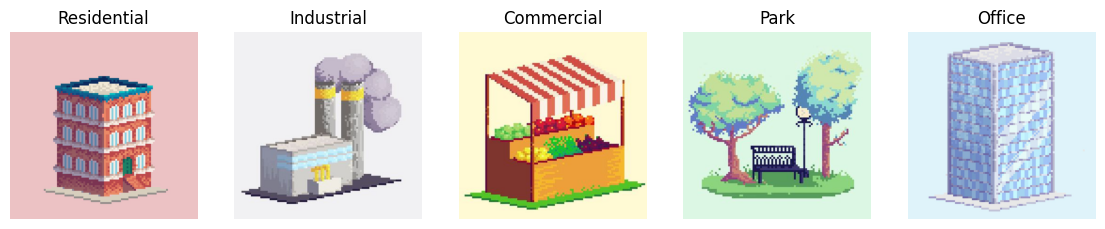

Grids: (500000, 7, 7) Ratings: (500000, 4)
Advisor 0  R2 Train=0.9115  Test=0.8328
Advisor 0  R2 Train=0.9149  Test=0.8305
Advisor 0  R2 Train=0.9222  Test=0.8396


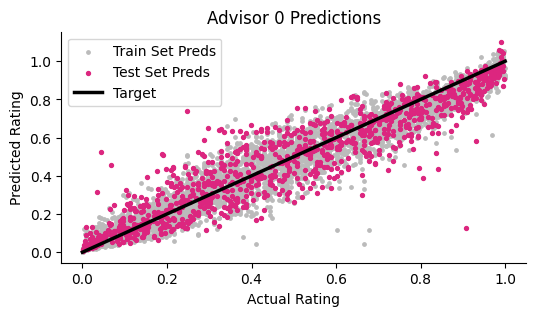

Advisor 0 Train Set R2 score: 0.9291
Advisor 0 Test  Set R2 score: 0.8531
Advisor 1  R2 Train=0.9760  Test=0.9634
Advisor 1  R2 Train=0.9780  Test=0.9673
Advisor 1  R2 Train=0.9792  Test=0.9697


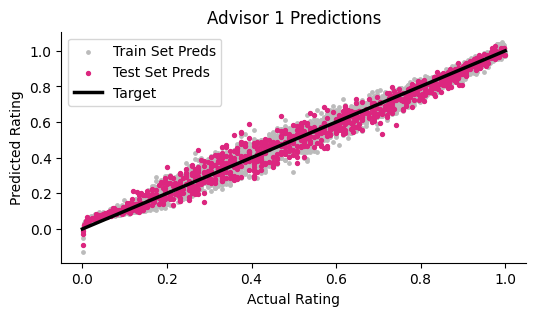

Advisor 1 Train Set R2 score: 0.9832
Advisor 1 Test  Set R2 score: 0.9739
Advisor 2  R2 Train=0.9547  Test=0.9231
Advisor 2  R2 Train=0.9573  Test=0.9191
Advisor 2  R2 Train=0.9482  Test=0.9072


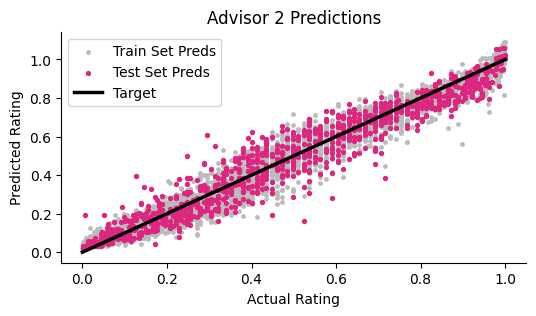

Advisor 2 Train Set R2 score: 0.9649
Advisor 2 Test  Set R2 score: 0.9327
Advisor 3  R2 Train=0.9731  Test=0.9604
Advisor 3  R2 Train=0.9670  Test=0.9499
Advisor 3  R2 Train=0.9730  Test=0.9586


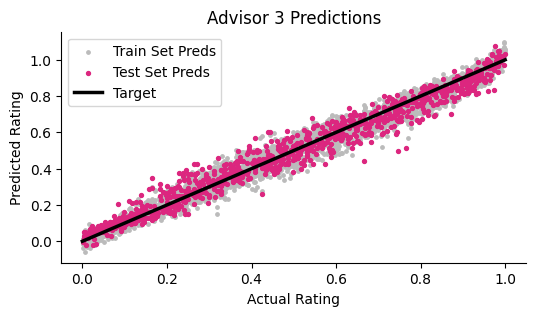

Advisor 3 Train Set R2 score: 0.9791
Advisor 3 Test  Set R2 score: 0.9661
submission.npy written with shape (100, 7, 7)


In [18]:
# ===============================================================
# CP2 + CNN with R2 improvements and Predicted-vs-Actual plots
# (PyTorch ReduceLROnPlateau fixed)
# ===============================================================

# 1) Environment
!git clone https://github.com/Lyleregenwetter/2155-Challenge-Problem-2
%cd 2155-Challenge-Problem-2/
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install scikit-learn matplotlib

# 2) Imports
import os, math, random, numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import utils_public as up

# 3) Global config
SEEDS = [42, 43, 44]       # light ensemble across seeds
BATCH = 128
EPOCHS = 250
LR = 3e-4
WD = 7e-4
PATIENCE = 20
DROPOUT = 0.25
USE_AUG = True             # symmetry-based data augmentation (train-time)
USE_TTA = False            # enable later if you want test-time augmentation

def set_seed(s):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4) Data loading
up.plot_districts()
grids = up.load_grids().astype(np.int64)           # (M, 7, 7)
ratings = np.load("datasets/scores.npy")           # (M, 4) with NaNs for unlabeled
assert grids.ndim == 3 and grids.shape[1:] == (7, 7)
assert ratings.ndim == 2 and ratings.shape[1] == 4
print("Grids:", grids.shape, "Ratings:", ratings.shape)

def select_rated_subset(grids_all, ratings_all, advisor_idx):
    mask = ~np.isnan(ratings_all[:, advisor_idx])
    return grids_all[mask], ratings_all[mask, advisor_idx]

# 5) Preprocessing and augmentation
def to_one_hot_5ch(grids_np):
    g = torch.as_tensor(grids_np, dtype=torch.long)
    oh = F.one_hot(g, num_classes=5)               # (N, 7, 7, 5)
    return oh.permute(0, 3, 1, 2).contiguous().float()  # (N, 5, 7, 7)

def augment_symmetries(x5ch):
    if not USE_AUG: return x5ch
    if torch.rand(()) < 0.5: x5ch = torch.flip(x5ch, dims=[-1])  # horizontal flip
    if torch.rand(()) < 0.5: x5ch = torch.flip(x5ch, dims=[-2])  # vertical flip
    k = torch.randint(0, 4, (1,)).item()                         # 0,90,180,270 deg
    if k: x5ch = torch.rot90(x5ch, k, dims=[-2, -1])
    return x5ch

def make_split(grids_sub, ratings_sub, test_size=0.2):
    X_tr, X_te, y_tr, y_te = train_test_split(grids_sub, ratings_sub, test_size=test_size, random_state=42)
    return X_tr, X_te, y_tr.astype(np.float32), y_te.astype(np.float32)

# 6) CNN architectures
class CityCNN1(nn.Module):
    """Compact CNN with two conv blocks and GAP head."""
    def __init__(self, in_ch=5, p=0.25):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),   nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(), nn.Dropout(p),
            nn.Linear(128, 64), nn.ReLU(inplace=True),
            nn.Dropout(p), nn.Linear(64, 1),
        )
    def forward(self, x):
        x = self.block1(x); x = self.block2(x); x = self.gap(x)
        return self.head(x)

class CityCNN1Plus(nn.Module):
    """Deeper/regularized CNN for tougher advisors (0 and 2)."""
    def __init__(self, in_ch=5, p_head=0.35, p_mid=0.10):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Dropout(p_mid),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Dropout(p_mid),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Dropout(p_mid),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(), nn.Dropout(p_head),
            nn.Linear(256, 128), nn.ReLU(inplace=True),
            nn.Dropout(p_head), nn.Linear(128, 1),
        )
    def forward(self, x):
        x = self.block1(x); x = self.block2(x); x = self.block3(x); x = self.gap(x)
        return self.head(x)

# 7) Training one advisor (ReduceLROnPlateau without deprecated verbose)
def train_one_advisor(grid_all, ratings_all, advisor_idx, seed=42):
    set_seed(seed)
    X_lab, y_lab = select_rated_subset(grid_all, ratings_all, advisor_idx)
    X_tr, X_te, y_tr, y_te = make_split(X_lab, y_lab, test_size=0.2)
    Xt_tr, Xt_te = to_one_hot_5ch(X_tr), to_one_hot_5ch(X_te)
    yt_tr, yt_te = torch.tensor(y_tr).view(-1, 1), torch.tensor(y_te).view(-1, 1)

    tr_ds = TensorDataset(Xt_tr, yt_tr)
    te_ds = TensorDataset(Xt_te, yt_te)
    tr_dl = DataLoader(tr_ds, batch_size=BATCH, shuffle=True)
    te_dl = DataLoader(te_ds, batch_size=BATCH, shuffle=False)

    model = (CityCNN1Plus(in_ch=5, p_head=0.35, p_mid=0.10) if advisor_idx in [0, 2]
             else CityCNN1(in_ch=5, p=DROPOUT)).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=4, threshold=1e-4, cooldown=0, min_lr=0.0, eps=1e-8
    )
    crit = nn.MSELoss()

    best_val, best_state, wait = float('inf'), None, 0
    for ep in range(1, EPOCHS+1):
        # train
        model.train(); tr_loss = 0.0
        for xb, yb in tr_dl:
            xb = augment_symmetries(xb)
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            gamma = 0.75  # try 0.5–1.0
            w = 1.0 + gamma * torch.abs(yb - 0.5) * 2.0  # weights in [1, 1+gamma]
            loss = (w * (pred - yb) ** 2).mean()
            #loss = crit(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            tr_loss += loss.item() * xb.size(0)
        tr_loss /= len(tr_dl.dataset)

        # validation
        model.eval(); va_loss = 0.0
        with torch.no_grad():
            for xb, yb in te_dl:
                xb, yb = xb.to(device), yb.to(device)
                va_loss += crit(model(xb), yb).item() * xb.size(0)
        va_loss /= len(te_dl.dataset)
        sched.step(va_loss)

        if va_loss < best_val - 1e-6:
            best_val, best_state, wait = va_loss, {k: v.cpu().clone() for k, v in model.state_dict().items()}, 0
        else:
            wait += 1
            if wait >= PATIENCE: break

    if best_state is not None: model.load_state_dict(best_state)
    model.to(device)

    # predictions for plots and R2 (train/test splits)
    model.eval()
    with torch.no_grad():
        ytr_pred = []
        for xb, yb in DataLoader(tr_ds, batch_size=BATCH):
            ytr_pred.append(model(xb.to(device)).cpu().numpy().reshape(-1))
        ytr_pred = np.concatenate(ytr_pred)
        yte_pred = []
        for xb, yb in DataLoader(te_ds, batch_size=BATCH):
            yte_pred.append(model(xb.to(device)).cpu().numpy().reshape(-1))
        yte_pred = np.concatenate(yte_pred)

    r2_tr = r2_score(y_tr, ytr_pred)
    r2_te = r2_score(y_te, yte_pred)
    print(f"Advisor {advisor_idx}  R2 Train={r2_tr:.4f}  Test={r2_te:.4f}")
    return model, (X_tr, y_tr, ytr_pred), (X_te, y_te, yte_pred)

# 8) Predicted vs Actual plots with R2
def plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, advisor):
    plt.figure(figsize=(6, 3))
    plt.scatter(ratings_train, preds_train, label='Train Set Preds', s=6, c="#BBBBBB")
    plt.scatter(ratings_test,  preds_test,  label='Test Set Preds',  s=8, c="#DC267F")
    plt.plot([0, 1], [0, 1], label="Target", linewidth=2.5, c="k")
    plt.xlabel("Actual Rating"); plt.ylabel("Predicted Rating"); plt.title(f"Advisor {advisor} Predictions")
    ax = plt.gca(); ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    plt.legend(); plt.show()
    print(f"Advisor {advisor} Train Set R2 score: {r2_score(ratings_train, preds_train):.4f}")
    print(f"Advisor {advisor} Test  Set R2 score: {r2_score(ratings_test,  preds_test):.4f}")

# 9) Train all 4 advisors with light seed-ensemble and plot
models = []
all_cols = []
for advisor in range(4):
    preds_tr_list, preds_te_list = [], []
    model_ref = None
    for s in SEEDS:
        model_s, (X_tr, y_tr, ytr_pred), (X_te, y_te, yte_pred) = train_one_advisor(grids, ratings, advisor, seed=s)
        preds_tr_list.append(ytr_pred); preds_te_list.append(yte_pred)
        model_ref = model_s
    preds_tr_mean = np.mean(np.stack(preds_tr_list, axis=0), axis=0)
    preds_te_mean = np.mean(np.stack(preds_te_list, axis=0), axis=0)
    plot_and_r2(preds_tr_mean, preds_te_mean, y_tr, y_te, advisor)

    # full-dataset prediction and merge (keep labels, fill NaNs with model predictions)
    def predict_full(model, grids_all, batch=4096):
        model.eval(); out=[]
        ds = TensorDataset(to_one_hot_5ch(grids_all))
        dl = DataLoader(ds, batch_size=batch, shuffle=False)
        with torch.no_grad():
            for (xb,) in dl:
                out.append(model(xb.to(device)).cpu().numpy().reshape(-1))
        return np.concatenate(out)

    def predict_full_tta(model, grids_all, batch=4096, n_aug=6):
        base = to_one_hot_5ch(grids_all)
        acc = None
        for t in range(n_aug):
            x = base.clone()
            k = torch.randint(0,4,(1,)).item()
            if k: x = torch.rot90(x, k, dims=[-2,-1])
            if t % 2 == 0: x = torch.flip(x, dims=[-1])
            if t % 3 == 0: x = torch.flip(x, dims=[-2])
            preds=[]
            dl = DataLoader(TensorDataset(x), batch_size=batch, shuffle=False)
            with torch.no_grad():
                for (xb,) in dl:
                    preds.append(model(xb.to(device)).cpu().numpy().reshape(-1))
            p = np.concatenate(preds)
            acc = p if acc is None else acc + p
        return acc / float(n_aug)

    col_full = ratings[:, advisor].copy()
    mask_nan = np.isnan(col_full)
    # **NEW: use TTA for advisors 0 and 2 if enabled**
    if advisor in [0, 2] and USE_TTA:
        col_full[mask_nan] = predict_full_tta(model_ref, grids)[mask_nan]
    else:
        col_full[mask_nan] = predict_full(model_ref, grids)[mask_nan]
    all_cols.append(col_full)

final_prediction_array = np.stack(all_cols, axis=1)  # (M, 4)

# 10) Select top-100 by highest minimum across advisors
min_predictions = final_prediction_array.min(axis=1)
top_100_indices = np.argpartition(min_predictions, -100)[-100:]
top_100_indices = top_100_indices[np.argsort(-min_predictions[top_100_indices])]

# 11) Save submission
final_submission = grids[top_100_indices].astype(int)
assert final_submission.shape == (100, 7, 7)
assert final_submission.dtype == int
assert np.all((final_submission >= 0) & (final_submission <= 4))
np.save("submission3.npy", final_submission)
print("submission.npy written with shape", final_submission.shape)


In [20]:
print(final_prediction_array.shape)

min_predictions = np.min(final_prediction_array, axis=1) #minimum advisor score (as predicted)
print(f"Number of valid grids (as predicted): {np.sum(min_predictions>0.75)}") #number of valid grids (as predicted)

(500000, 4)
Number of valid grids (as predicted): 780


In [78]:
# ===============================================================
# Block: rotate (90°, 270°) + flip (H, V) valid grids, merge, select diverse top-100
# Requires: grids, final_prediction_array, utils_public as up,
#           greedy_fps_hamming, hill_climb_improve
# ===============================================================

import numpy as np

# 1) Valid set with your current threshold (re-using min_predictions)
valid_mask = min_predictions > 0.87
valid_idx = np.where(valid_mask)[0]
grids_valid = grids[valid_idx].astype(np.int16)
print("Valid source:", grids_valid.shape)

# 2) Generate transforms from valids
rot90  = np.rot90(grids_valid, k=1, axes=(1,2))
rot270 = np.rot90(grids_valid, k=3, axes=(1,2))
flip_h = np.flip(grids_valid, axis=2)   # horizontal mirror (flip columns)
flip_v = np.flip(grids_valid, axis=1)   # vertical   mirror (flip rows)

# 3) Merge originals + transforms
merged = np.concatenate([grids_valid, rot90, rot270, flip_h, flip_v], axis=0)

# 4) Deduplicate exact duplicates
flat = merged.reshape(merged.shape[0], -1)
uniq_flat, uniq_idx = np.unique(flat, axis=0, return_index=True)
merged_unique = merged[uniq_idx]
print("Merged unique pool:", merged_unique.shape)

# 5) Select 100 diverse with FPS + hill-climb
V2 = merged_unique.shape[0]
flat_merged = merged_unique.reshape(V2, -1)

# Seed scores optional (distance dominates); keep zeros
seed_score = np.zeros(V2, dtype=float)

seed_sel = greedy_fps_hamming(flat_merged, k=100, seed_choice="best_score",
                              score=seed_score, alpha=0.7)

# Ensure hill_climb_improve evaluates diversity on this merged pool
_grids_valid_backup = grids_valid
grids_valid = merged_unique
best_sel, best_div = hill_climb_improve(seed_sel, patience=600, max_trials=3000)
grids_valid = _grids_valid_backup
print(f"Diversity Score (valid + rot90 + rot270 + flipH + flipV): {best_div:.4f}")

# 6) Save final 100
final_submission_diverse_rot = merged_unique[best_sel].astype(int)
assert final_submission_diverse_rot.shape == (100, 7, 7)
assert np.all((final_submission_diverse_rot >= 0) & (final_submission_diverse_rot <= 4))
np.save("submission_diverse_rot_flip_2.npy", final_submission_diverse_rot)
print("submission_diverse_rot_flip.npy written with shape", final_submission_diverse_rot.shape)


Valid source: (209, 7, 7)
Merged unique pool: (1045, 7, 7)
Diversity Score (valid + rot90 + rot270 + flipH + flipV): 0.6032
submission_diverse_rot_flip.npy written with shape (100, 7, 7)


In [66]:
!git clone https://github.com/Lyleregenwetter/2155-Challenge-Problem-2
%cd 2155-Challenge-Problem-2/
from utils_public import *



Cloning into '2155-Challenge-Problem-2'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 68 (delta 2), reused 1 (delta 1), pack-reused 64 (from 1)
Receiving objects: 100% (68/68), 52.85 MiB | 27.28 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/2155-Challenge-Problem-2/2155-Challenge-Problem-2/2155-Challenge-Problem-2/2155-Challenge-Problem-2/2155-Challenge-Problem-2


<Figure size 640x480 with 0 Axes>

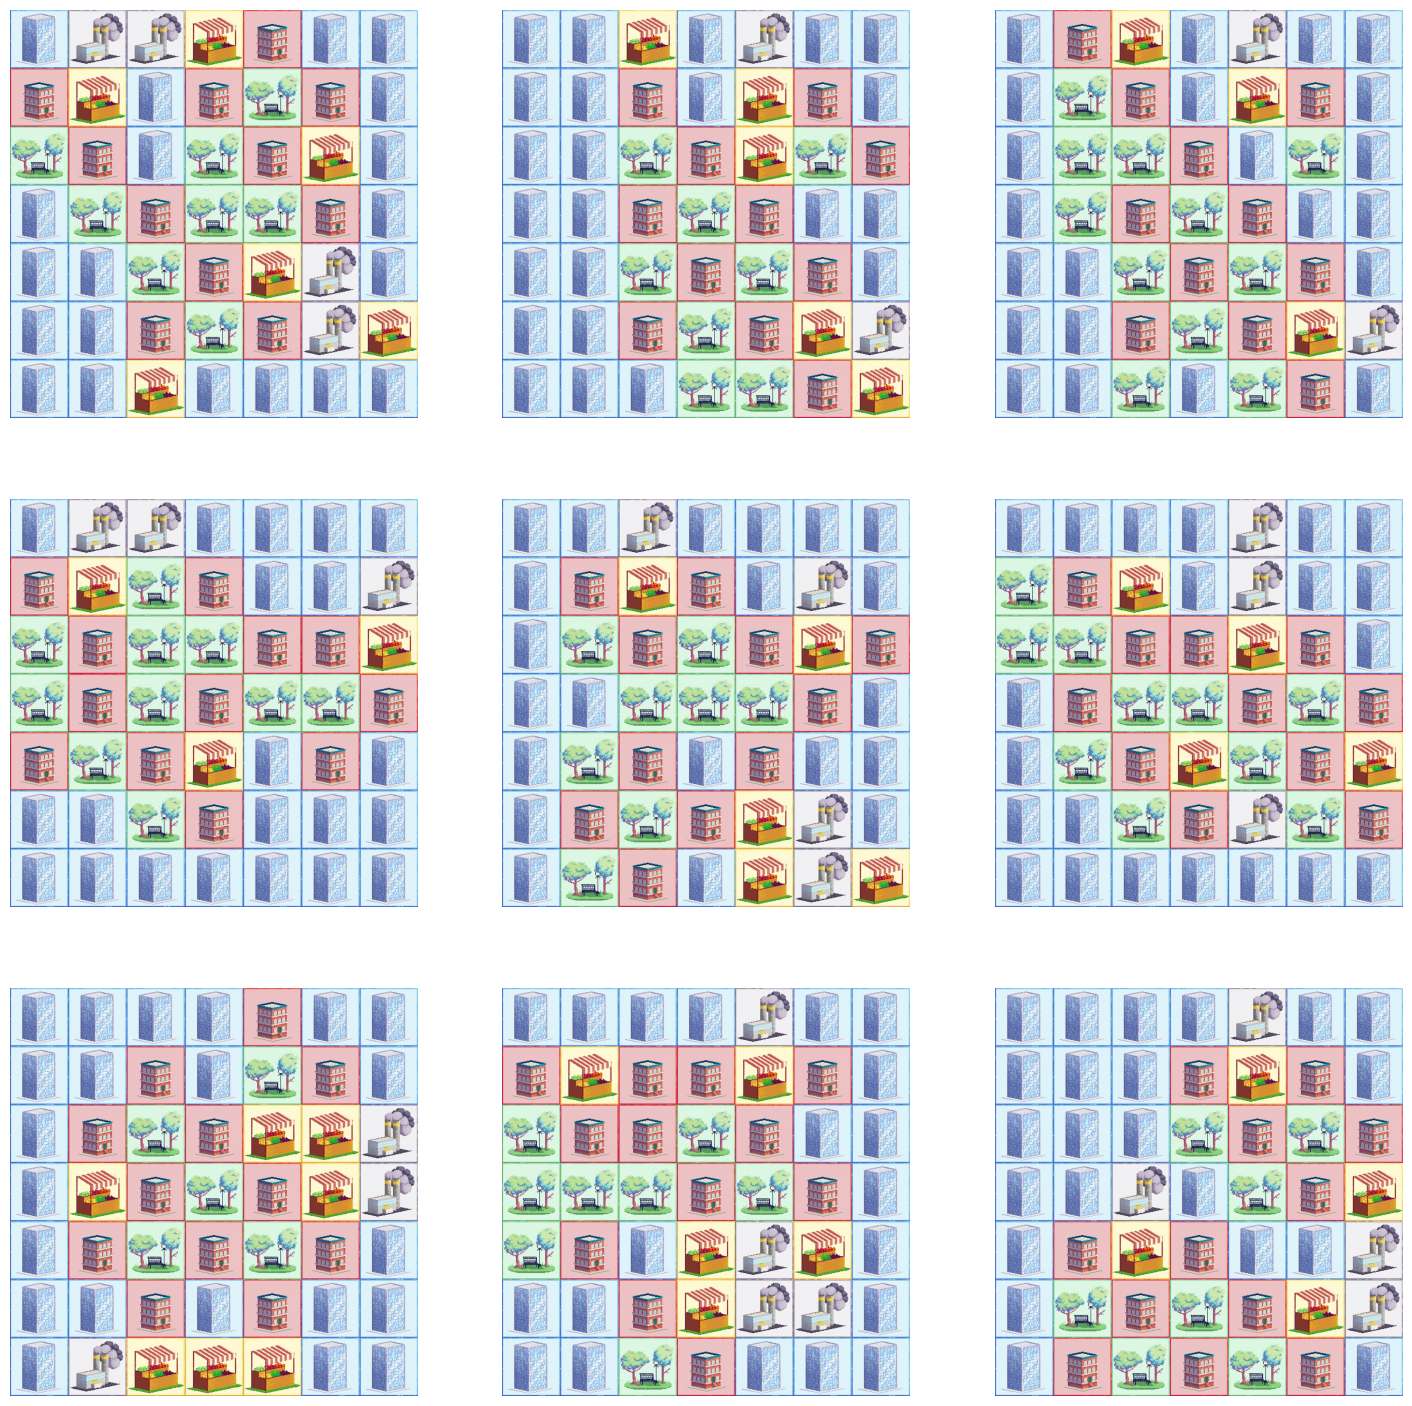

In [67]:
plot_n_grids(final_submission_diverse[:9])
